<a href="https://colab.research.google.com/github/armandochernandez-ai/Curso-python-slava/blob/main/Clima/Clima_SPEI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Procesada estación: 14002
Procesada estación: 14004
Procesada estación: 14005
Procesada estación: 14006
Procesada estación: 14007
Procesada estación: 14008


KeyboardInterrupt: 

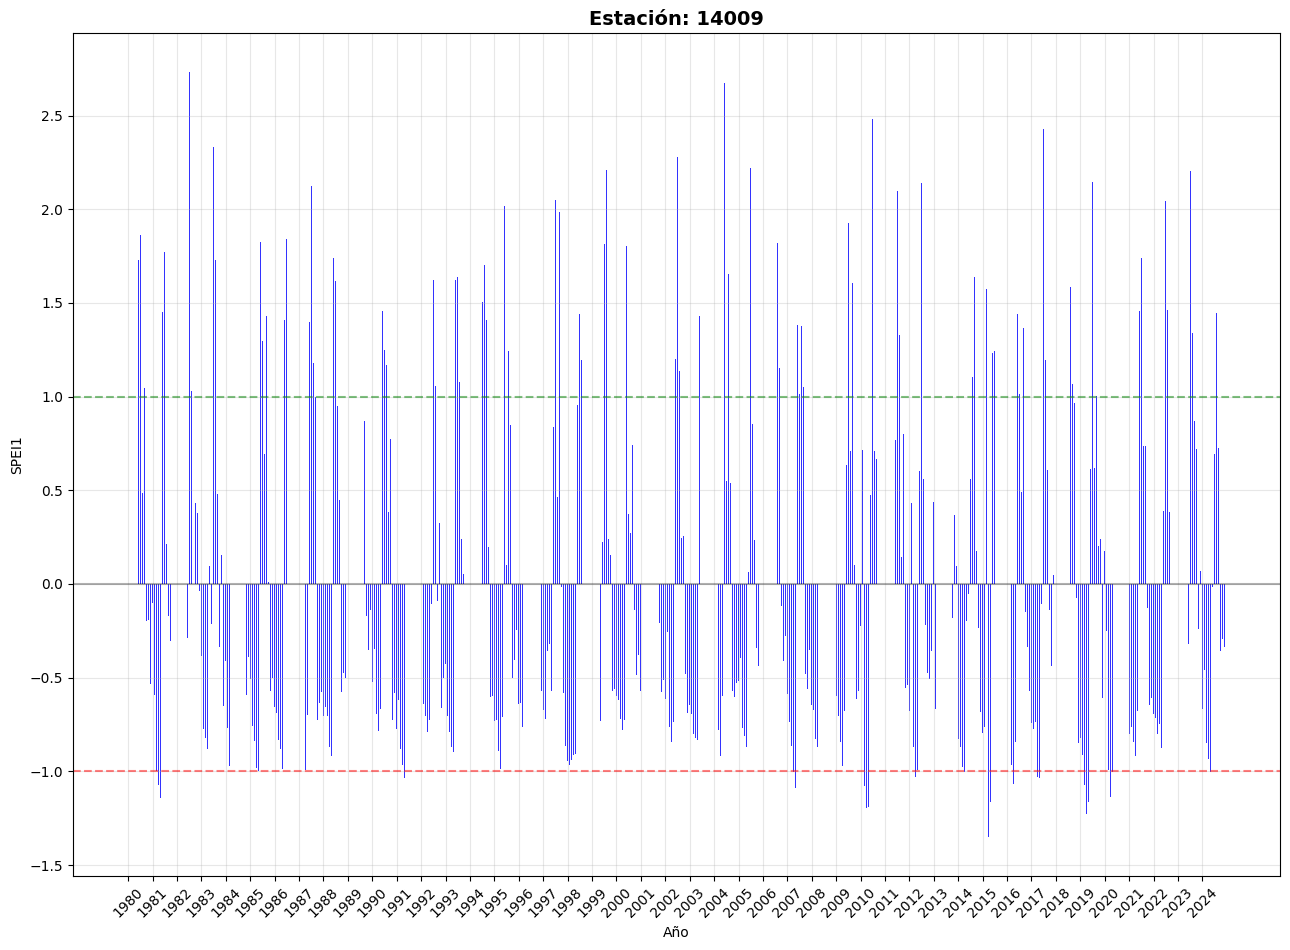

In [5]:
#El script original fue elaborado para Rstudio, se adaptó para que funcione en esta plataforma

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Montar Google Drive
drive.mount('/content/drive')

# Configuración de rutas
input_path = '/content/drive/MyDrive/Clima_Jalisco'
output_path = '/content/drive/MyDrive/Clima_Jalisco/IMAGENES_SPEI'

# Crear directorio de salida si no existe
os.makedirs(output_path, exist_ok=True)

# Cargar datos
estaciones_jalmes_FL = pd.read_csv(f'{input_path}/estaciones_jalmes_FL.csv')

# Función para calcular PET usando Thornthwaite
def thornthwaite(temperature, lat, months):
    """
    Calcula la Evapotranspiración Potencial usando el método de Thornthwaite
    """
    # Coeficientes para el cálculo
    pet_values = []
    for i, temp in enumerate(temperature):
        month = months[i]
        # Horas de luz del día (aproximación)
        if lat >= 0:  # Hemisferio norte
            day_hours = [10.5, 11.0, 12.0, 13.0, 14.0, 14.5,
                        14.5, 13.5, 12.5, 11.5, 10.5, 10.0]
        else:  # Hemisferio sur
            day_hours = [14.5, 13.5, 12.5, 11.5, 10.5, 10.0,
                        10.5, 11.0, 12.0, 13.0, 14.0, 14.5]

        if temp > 0:
            heat_index = (temp / 5) ** 1.514
            pet = 16 * (10 * temp / heat_index) ** (0.5 + 0.01 * lat) * day_hours[month-1] / 12
        else:
            pet = 0
        pet_values.append(pet)
    return pet_values

# Función para calcular SPEI
def calculate_spei(balance, scale=1):
    """
    Calcula el SPEI para una escala dada
    """
    # Rolling mean para la escala
    balance_roll = pd.Series(balance).rolling(window=scale, min_periods=1).mean()

    # Ajuste de distribución gamma (simplificado)
    spei_values = []
    for i in range(len(balance_roll)):
        if i >= scale-1:
            window_data = balance_roll[max(0, i-11):i+1]  # Ventana de 12 meses
            if len(window_data) >= 6:  # Mínimo de datos para cálculo
                # Estandarización simple (aproximación)
                z_score = (balance_roll.iloc[i] - window_data.mean()) / window_data.std()
                spei_values.append(z_score if not np.isnan(z_score) else 0)
            else:
                spei_values.append(0)
        else:
            spei_values.append(0)

    return spei_values

# Función para procesar cada estación
def procesar_estacion(codigo):
    try:
        # Filtrar datos de la estación
        estacion = estaciones_jalmes_FL[estaciones_jalmes_FL['Codigo'] == codigo].copy()

        # Ordenar por año y mes
        estacion = estacion.sort_values(['Year', 'Month'])

        # Calcular PET y Balance Hídrico
        estacion['PET'] = thornthwaite(estacion['tprom'].values,
                                     estacion['latitud'].iloc[0],
                                     estacion['Month'].values)
        estacion['BAL'] = estacion['p'] - estacion['PET']

        # Calcular SPEI-1
        spei1 = calculate_spei(estacion['BAL'].values, scale=1)
        estacion['SPEI1'] = spei1

        # Gráfico SPEI básico
        plt.figure(figsize=(13, 9.6))
        plt.bar(estacion['Year'] + (estacion['Month']-1)/12, estacion['SPEI1'],
                width=0.03, alpha=0.8, color='blue')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=1, color='green', linestyle='--', alpha=0.5)
        plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5)
        plt.title(f'Estación: {codigo}', fontsize=14, fontweight='bold')
        plt.xlabel('Año')
        plt.xticks(np.arange(1980, 2025, 1), rotation=45)
        plt.ylabel('SPEI1')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_path}/spei1_{codigo}.png', dpi=400, bbox_inches='tight')
        plt.close()

        # Preparar datos para gráfico de barras
        estacion['Period'] = estacion['Year'] + (estacion['Month'] - 1) / 12
        estacion['sing'] = estacion['SPEI1'].apply(lambda x: 'Húmedo' if x >= 0 else 'Seco')

        # Gráfico ggplot2 mejorado (estilo similar)
        plt.figure(figsize=(13, 9.6))

        # Crear gráfico de barras
        colors = {'Húmedo': 'blue', 'Seco': 'red'}
        for i, row in estacion.iterrows():
            plt.bar(row['Period'], row['SPEI1'],
                   color=colors[row['sing']],
                   width=0.03, alpha=0.8)

        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.ylim(-3, 3)
        plt.yticks(range(-3, 3))
        plt.xticks(np.arange(1994, 2025, 1), rotation=45)
        plt.xlim(1993.5, 2024.5)

        # Obtener nombre de la estación
        site_name = estacion['site'].iloc[0] if 'site' in estacion.columns else f"Estación {codigo}"

        plt.ylabel('SPEI', fontstyle='italic', fontweight='bold', fontsize=9)
        plt.xlabel('Año', fontstyle='italic', fontweight='bold', fontsize=10)
        plt.title(f'ESTACIÓN {site_name} (SMN: {codigo})\nÍndice Estandarizado de Evapotranspiración',
                 fontweight='bold', fontsize=14, pad=20)

        # Añadir leyenda
        import matplotlib.patches as mpatches
        humid_patch = mpatches.Patch(color='blue', label='Húmedo')
        dry_patch = mpatches.Patch(color='red', label='Seco')
        plt.legend(handles=[humid_patch, dry_patch],
                  loc='lower right',
                  bbox_to_anchor=(0.95, 0.05),
                  frameon=True,
                  framealpha=1,
                  edgecolor='black')

        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(fontstyle='italic', fontweight='bold', fontsize=8)
        plt.yticks(fontstyle='italic', fontweight='bold', fontsize=8)

        # Añadir texto del índice
        #plt.text(0.02, 0.98, 'ÍNDICE ESTANDARIZADO DE EVAPOTRANSPIRACIÓN',
                #transform=plt.gca().transAxes,
                #fontsize=10, verticalalignment='top')

        plt.tight_layout()
        plt.savefig(f'{output_path}/ESTACION_{codigo}.png', dpi=400, bbox_inches='tight')
        plt.close()

        print(f"Procesada estación: {codigo}")

    except Exception as e:
        print(f"Error en estación {codigo}: {str(e)}")

# Procesar todas las estaciones únicas
estaciones_unicas = estaciones_jalmes_FL['Codigo'].unique()

for codigo in estaciones_unicas:
    procesar_estacion(codigo)

print("Procesamiento completado!")